# Data driven prediction models of energy use of appliances in a low-energy house

## Portfolio 2

By Samuel Hornsey
44851375

### Introduction

The academic paper "Data driven prediction models of energy use of appliances in a low-energy house" by Luis M. Candanedo, Véronique Feldheim and Dominique Deramaix uses the programming language R to develop a data driven prediction of household appliance energy usage. In the field of scientific research, results must be consistent and reproducable. This paper will recreate certain aspects of the analysis using Python and compare the results to what was originally stated in the paper. As stated in the paper this model can be useful in estimating power consumption and detecting abnormal energy use patterns. In this project there will also be a demonstration of how this model could be deployed in a useful format for end users to make predictions about appliance energy usage in their own homes.

In [29]:
# Imports
import pandas as pd
import numpy as np
import math
import sys
from datetime import timedelta, datetime

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import ensemble
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 15, 6

### Preparing The Data

In the study there are a number of derived fields used. Theses are number of seconds from midnight (NSM), day of the week and weekend status. To best simulate these results the following algorithms have been used to derive these fields from the dataset.

In [30]:
df = pd.read_csv('../data/energydata_complete.csv')

def seconds_to_midnight(date):
    time = datetime.strptime(date, '%Y-%m-%d %H:%M:%S').time()
    
    h, m, s = str(time).split(':')
    
    return (int(h) * 3600 + int(m) * 60 + int(s))

def day_of_week(date):
    date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    
    return date.weekday()

def is_weekend(day_of_week):
    if day_of_week == 5 or day_of_week == 6:
        return 0
    return 1
    
df['NSM'] = df['date'].apply(lambda row: seconds_to_midnight(row))
df['day_of_week'] = df['date'].apply(lambda row: day_of_week(row))
df['weekday_status'] = df['day_of_week'].apply(lambda row: is_weekend(row))


df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,NSM,day_of_week,weekday_status
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,61200,0,1
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,61800,0,1
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,62400,0,1
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,63000,0,1
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,63600,0,1


### About The Data

A number of sensors were placed around a small to medium home in Belgium. These sensors detected temperature, appliance usage, light usage etc. The data set used in the study was supplied in a [github repository](https://github.com/LuisM78/Appliances-energy-prediction-data). The same data will be used in this Python analysis. In the data set, two random variables were introduced. These are named 'rv1' and 'rv2'. In the study these were used as part of the feature selection process. These features will not be used in this Python analysis and will be dropped in data preparation.

In [31]:
df = df.drop(columns=['rv1', 'rv2'])

df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,NSM,day_of_week,weekday_status
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,42907.129465,2.977249,0.722726
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,24940.020831,1.985617,0.447664
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,21600.000000,1.000000,0.000000
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,43200.000000,3.000000,1.000000
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,64200.000000,5.000000,1.000000
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,85800.000000,6.000000,1.000000


### Appliance Data Over Time

The following two graphs show the appliance energy usesage over time. 

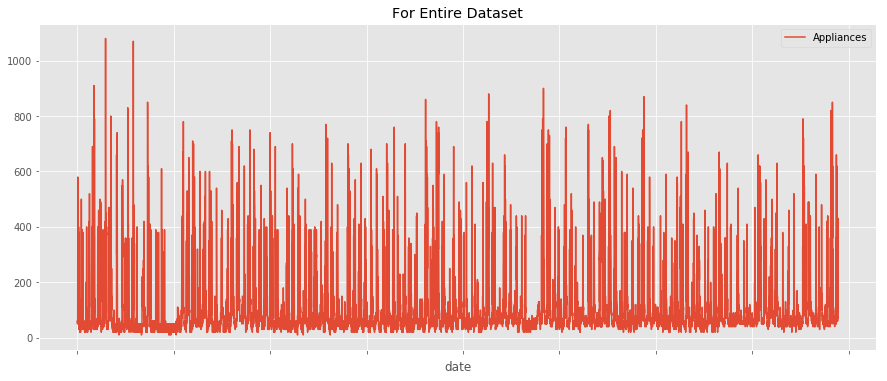

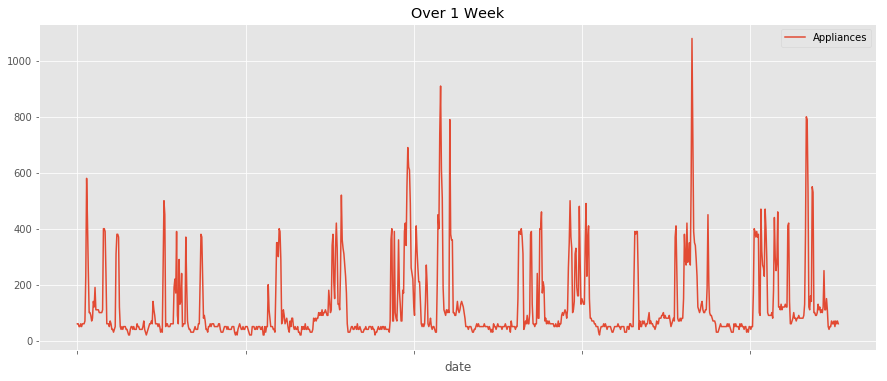

In [32]:
df.plot(x='date', y='Appliances', title='For Entire Dataset')

plt.show()

df.loc[(df['date'] > '2016-01-11') & (df['date'] <= '2016-01-18')].plot(x='date', y='Appliances', title='Over 1 Week')

plt.show()

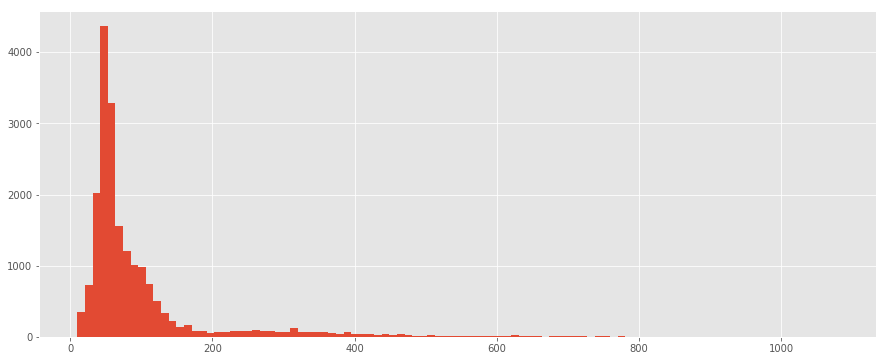

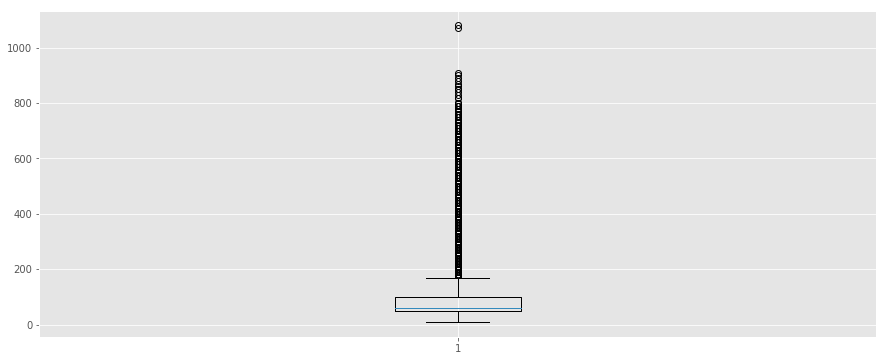

In [33]:
df['Appliances'].hist(bins=100)

plt.show()

plt.boxplot(df['Appliances'])

plt.show()

These graphs perfectly match graphs shown in the study. Which therefore highlights that there is no discrepency between the studies data set and the data set being used in the portfolio.

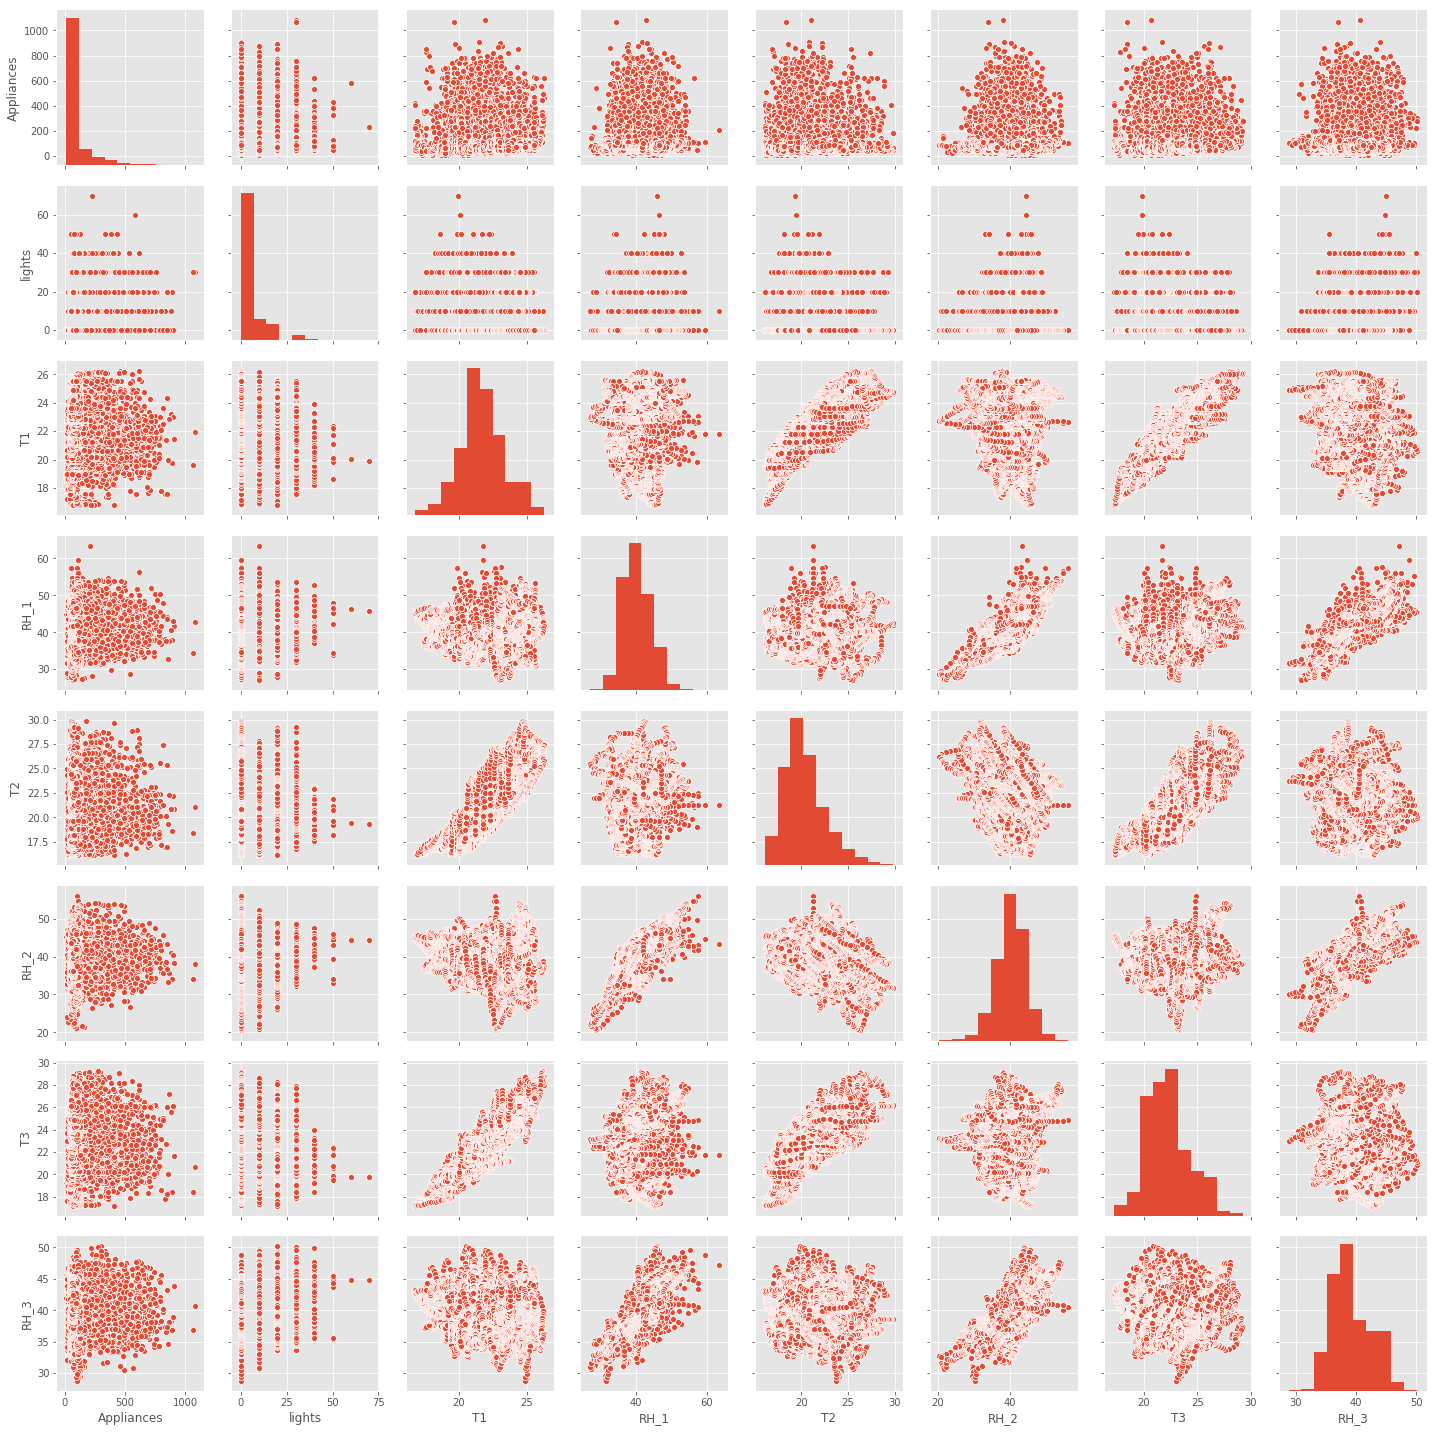

In [34]:
sns.pairplot(df[['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3']])

In [35]:
df.corr()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,NSM,day_of_week,weekday_status
Appliances,1.000000,0.197278,0.055447,0.086031,0.120073,-0.060465,0.085060,0.036292,0.040281,0.016965,...,-0.051462,0.099155,-0.034885,-0.152282,0.087122,0.000230,0.015353,0.217152,0.003060,-0.017437
lights,0.197278,1.000000,-0.023528,0.106968,-0.005622,0.050985,-0.097393,0.131161,-0.008859,0.114936,...,-0.008766,-0.074424,-0.010576,0.068543,0.060281,0.020038,-0.036322,0.254993,-0.099828,0.051404
T1,0.055447,-0.023528,1.000000,0.164006,0.836834,-0.002509,0.892402,-0.028550,0.877001,0.097861,...,0.071756,0.682846,-0.150574,-0.345481,-0.087654,-0.076210,0.571309,0.178728,0.001381,-0.010885
RH_1,0.086031,0.106968,0.164006,1.000000,0.269839,0.797535,0.253230,0.844677,0.106180,0.880359,...,0.764001,0.340767,-0.293957,0.274126,0.204932,-0.021057,0.639106,0.018531,-0.053782,0.018641
T2,0.120073,-0.005622,0.836834,0.269839,1.000000,-0.165610,0.735245,0.121497,0.762066,0.231563,...,0.157346,0.792255,-0.133028,-0.505291,0.052495,-0.069721,0.582602,0.254569,0.000602,0.005065
RH_2,-0.060465,0.050985,-0.002509,0.797535,-0.165610,1.000000,0.137319,0.678326,-0.047304,0.721435,...,0.676467,0.033674,-0.255646,0.584911,0.069190,-0.005368,0.499152,-0.183182,-0.044249,0.001965
T3,0.085060,-0.097393,0.892402,0.253230,0.735245,0.137319,1.000000,-0.011234,0.852778,0.122737,...,0.134602,0.699417,-0.189974,-0.281718,-0.100776,-0.102310,0.645886,0.037607,-0.017514,0.009326
RH_3,0.036292,0.131161,-0.028550,0.844677,0.121497,0.678326,-0.011234,1.000000,-0.140457,0.898978,...,0.833538,0.118207,-0.233274,0.356192,0.263188,0.017041,0.414387,-0.052343,-0.035182,0.013382
T4,0.040281,-0.008859,0.877001,0.106180,0.762066,-0.047304,0.852778,-0.140457,1.000000,-0.048650,...,-0.025549,0.663478,-0.075292,-0.388602,-0.185747,-0.104768,0.519471,0.088334,-0.091006,0.093141
RH_4,0.016965,0.114936,0.097861,0.880359,0.231563,0.721435,0.122737,0.898978,-0.048650,1.000000,...,0.856591,0.293289,-0.250748,0.336813,0.300192,0.002636,0.616509,-0.019040,-0.005749,-0.031205


### Pariplot and Correlation

The study showed a number pairplots comparing the appliance data variable with other variables. In addition, the R pairplot used in the study also showed the correlations between variables. To simulate this in Python, the pandas correlation table has been used.

### Linear Regression

The above pair plot shows the correlations between different features in the datset. The main row to look at is the top row, which shows the correlations for the appliance field. To create a linear regression for the dataset we will take a train, test split and perform the calculations. This will then be compared with the train, test split provided in the study.

In [36]:
reg = linear_model.LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['date', 'Appliances']), df['Appliances'], test_size=0.33, random_state=42)

reg.fit(X_train, y_train)

predicted = reg.predict(X_test)

mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
print("MSE:", mse)
print("RMSE", math.sqrt(mse))
print("R Squared:", r2)

MSE: 8735.206259175942
RMSE 93.46232534650495
R Squared: 0.166187358780022


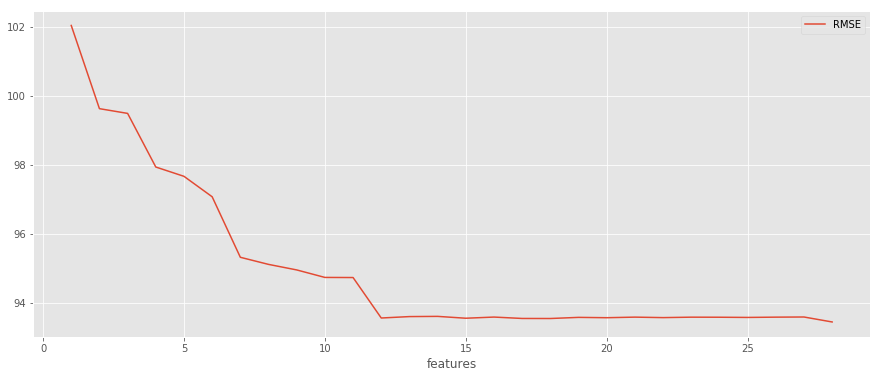

In [37]:
features = 1
results = {
    'RMSE': [],
    'features': []
}

# Function to peform RFE
def rfe_features(features):
    reg = linear_model.LinearRegression()
    rfe = RFE(reg, n_features_to_select=features)

    rfe.fit(X_train, y_train)

    predicted = rfe.predict(X_test)
    
    mse = mean_squared_error(y_test, predicted)
    r2 = r2_score(y_test, predicted)
    
    results['RMSE'].append(math.sqrt(mse))
    results['features'].append(features)
    
    if features >= len(list(X_train)):
        return
    else:
        features += 1
        # Recurse that function...
        rfe_features(features)
        
rfe_features(features)
res = pd.DataFrame(results)
res.plot(x='features', y='RMSE')

### Recurisive Feature Estimation

In the study they show that the accuracy of the model improves as more features are used in the model. The graph above plots the number of features vs the root mean squared error. The graph clearly shows that as number of features increases the root mean squared error decreases. Meaning that the model gets more accurate, as more features are included.

### Using Other Regression Methods

In the study they also employed some other machine learning methods. Below are examples of the randome forest regressor and the gradient boosting regressor. Where possible the same tuning parameters were used as stated in the study. None of the machine learning algorithms were able to produce outstanding accuracy for the data set. Therefore, showing that a different feature set is required to improve the machine learning model accuracy.

In [38]:
reg = ensemble.RandomForestRegressor(n_estimators=300, random_state=18)

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['date', 'Appliances']), df['Appliances'], test_size=0.33, random_state=42)

reg.fit(X_train, y_train)

predicted = reg.predict(X_test)

mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
print("MSE:", mse)
print("RMSE", math.sqrt(mse))
print("R Squared:", r2)

MSE: 4784.555630619104
RMSE 69.17048236508911
R Squared: 0.5432937873401991


In [39]:
reg = ensemble.GradientBoostingRegressor()

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['date', 'Appliances']), df['Appliances'], test_size=0.33, random_state=42)

reg.fit(X_train, y_train)

predicted = reg.predict(X_test)

mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
print("MSE:", mse)
print("RMSE", math.sqrt(mse))
print("R Squared:", r2)

MSE: 7296.232410732312
RMSE 85.41798645913114
R Squared: 0.30354354129224237


### Persisting The Model For Production

None of the models had very strong results for machine learning. The best results were from the RandomForestRegressor. To launch this model in a production environment it must be saved into a persistent format.

For a production example, I want to deploy this model in the form of a web app where users can enter data collected from their own house and recieve and estimate for their appliance energy usage. This does however mean that a number of features will not be applicable as they were specific to the house used in the study. For example, the room temperatures would not be useful as different houses have different rooms etc. For this model the chosen features were general enough to apply for any household. Such as lights energy useage, temperature outside, humidty outside.

In [40]:
reg = ensemble.RandomForestRegressor(n_estimators=300, random_state=18)

X_train, X_test, y_train, y_test = train_test_split(df[['lights', 'NSM', 'Press_mm_hg', 'T_out', 'RH_out']], df['Appliances'], test_size=0.33, random_state=42)

reg.fit(X_train, y_train)

predicted = reg.predict(X_test)

mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)
print("MSE:", mse)
print("RMSE", math.sqrt(mse))
print("R Squared:", r2)

MSE: 4889.0246512103995
RMSE 69.92156070347973
R Squared: 0.5333217743847649


In the random forest regressor the reduction in features does not have a massive overall affect on the model accuracy. 

In [41]:
test_df = pd.DataFrame.from_dict({
    'lights': [30],
    'NSM': [1000],
    'Press_mm_hg': [20],
    'T_out': [10],
    'RH_out': [20]
})

reg.predict(test_df)

array([86.73333333])

In [42]:
from sklearn.externals import joblib
joblib.dump(reg, '../app/models/clf.pkl') 

['../app/models/clf.pkl']

### Running the Production Example

```console
docker-compose up -d
```